## Libraries


In [241]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# import plotly.express as px

## Constants


In [242]:
file_path = "..\\..\\mpu6050_data_New.csv"
filtered_file_path = "..\\mpu6050_filtered_kalman_New.csv"
output_file = "..\\mpu6050_filtered_adaptive_New.csv"

## Loading the data


In [243]:
df = pd.read_csv(file_path)
df

,timestamp,yaw,pitch,roll,ax,ay,az
0,0.021159,3.93,9.48,0.80,0.00,-0.0,0.01
1,0.056834,3.93,9.49,0.80,0.00,0.0,0.00
2,0.095691,3.94,9.49,0.81,-0.00,0.0,-0.00
3,0.140188,3.94,9.49,0.81,0.01,0.0,0.00
4,0.180905,3.94,9.49,0.81,0.00,0.0,0.01
...,...,...,...,...,...,...,...
244,9.874166,8.56,9.79,0.53,-0.00,-0.0,0.00
245,9.911680,8.56,9.79,0.53,-0.00,0.0,0.01
246,9.955188,8.56,9.79,0.53,0.00,-0.0,0.01
247,9.994346,8.57,9.79,0.54,-0.00,-0.0,0.01


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  249 non-null    float64
 1   yaw        249 non-null    float64
 2   pitch      249 non-null    float64
 3   roll       249 non-null    float64
 4   ax         249 non-null    float64
 5   ay         249 non-null    float64
 6   az         249 non-null    float64
dtypes: float64(7)
memory usage: 13.7 KB


## Basic Statistics


In [245]:
df.drop("timestamp", axis=1).describe()

,yaw,pitch,roll,ax,ay,az
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,7.710241,10.020201,1.265863,0.005703,-0.000643,-0.006345
std,3.450120,6.413722,6.516095,0.107739,0.126333,0.153882
min,-37.900000,9.080000,0.070000,-1.150000,-0.790000,-1.560000
25%,7.180000,9.490000,0.600000,0.000000,-0.020000,-0.040000
50%,8.370000,9.630000,0.750000,0.000000,0.000000,0.010000
75%,8.560000,9.770000,1.110000,0.040000,0.020000,0.020000
max,12.120000,110.790000,103.520000,0.290000,0.560000,0.530000


In [246]:
columns_to_filter = df.columns.to_list()[1:]
columns_to_filter

['yaw', 'pitch', 'roll', 'ax', 'ay', 'az']

### This Section is Written BY GPTS (Be WAre) ':('


## Kalman Filter


In [247]:
def kalman_filter(z, Q=1e-5, R=0.01, initial_value=None):
    n_iter = len(z)
    xhat = np.zeros(n_iter)
    P = 1.0

    if initial_value is None:
        xhat[0] = z[0]
    else:
        xhat[0] = initial_value

    for k in range(1, n_iter):
        xhatminus = xhat[k - 1]
        Pminus = P + Q

        K = Pminus / (Pminus + R)
        xhat[k] = xhatminus + K * (z[k] - xhatminus)
        P = (1 - K) * Pminus

    return xhat

In [248]:
filtered_kalman_df = df.copy()
for col in columns_to_filter:
    filtered_kalman_df[col] = kalman_filter(df[col].values, Q=1e-5, R=0.01)


filtered_kalman_df.to_csv(filtered_file_path, index=False)

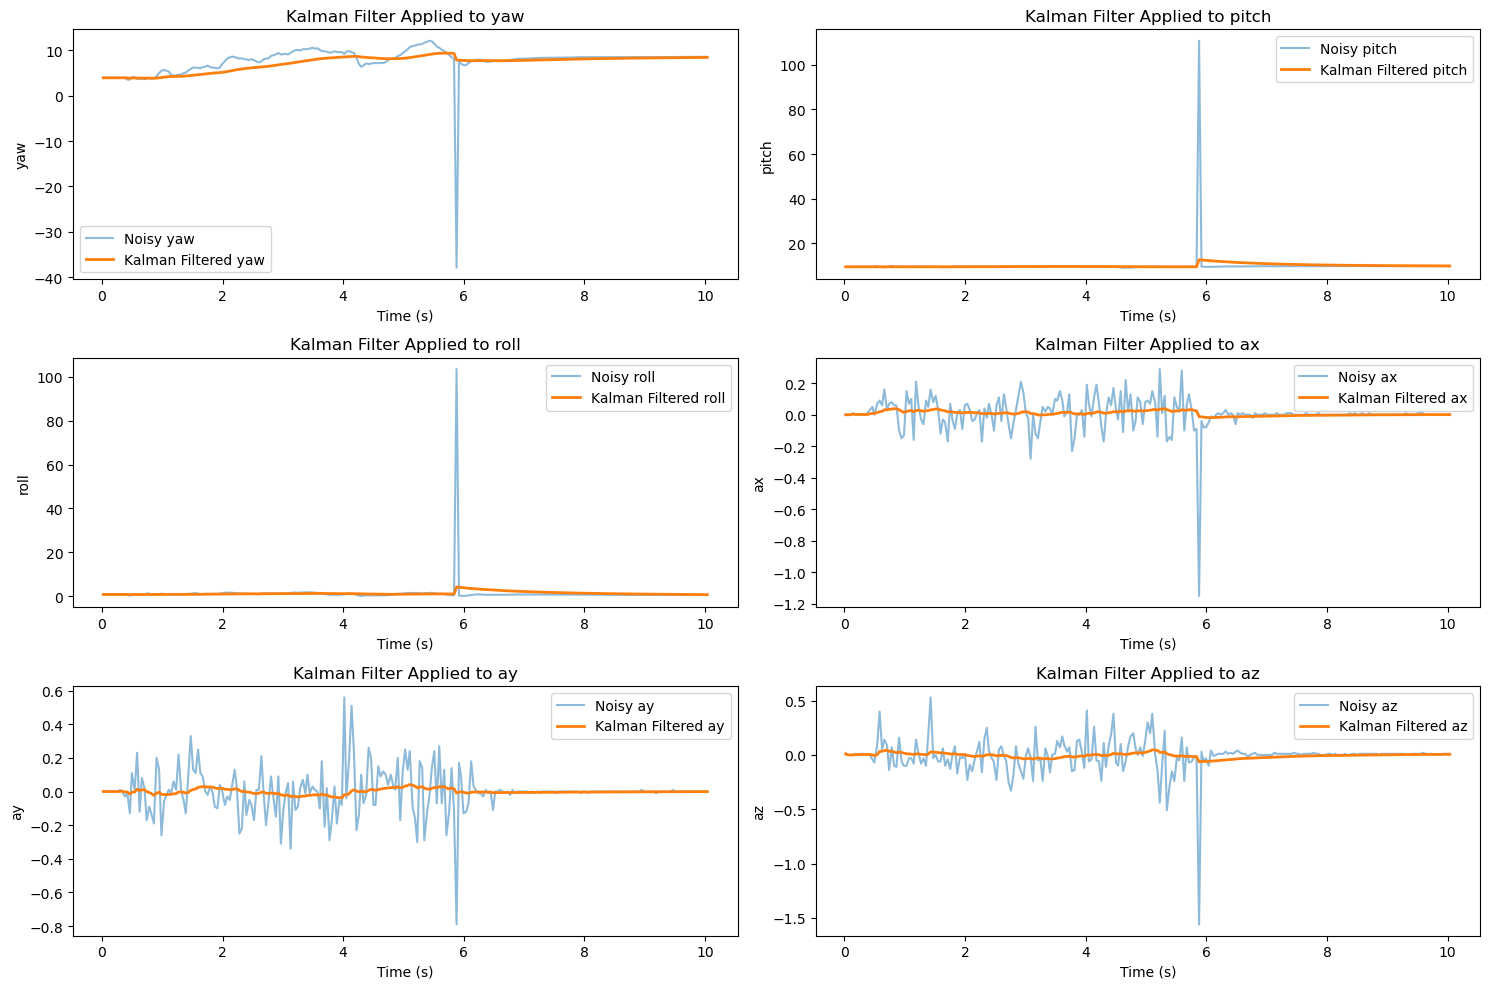

In [249]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_filter):
    plt.subplot(3, 2, i + 1)
    plt.plot(df["timestamp"], df[col], label=f"Noisy {col}", alpha=0.5)
    plt.plot(
        filtered_kalman_df["timestamp"],
        filtered_kalman_df[col],
        label=f"Kalman Filtered {col}",
        linewidth=2,
    )
    plt.xlabel("Time (s)")
    plt.ylabel(col)
    plt.legend()
    plt.title(f"Kalman Filter Applied to {col}")


plt.tight_layout()
plt.show()

## Another Approach


In [250]:
def apply_median_filter(data, kernel_size=3):
    return signal.medfilt(data, kernel_size=kernel_size)

In [251]:
import pandas as pd  # type: ignore

median_filtered_df = df.copy()


for col in columns_to_filter:

    median_filtered_df[col] = apply_median_filter(df[col].values, kernel_size=3)
median_filtered_df.to_csv("median_filtered_df.csv", index=False)

## Adaptive kalman filter


In [252]:
def adaptive_kalman_filter(z, Q=1e-5, R=0.01, threshold_factor=3, initial_value=None):
    n_iter = len(z)
    xhat = np.zeros(n_iter)
    P = 1.0

    xhat[0] = z[0] if initial_value is None else initial_value

    robust_std = np.std(z)

    for k in range(1, n_iter):
        xhatminus = xhat[k - 1]
        Pminus = P + Q

        innovation = z[k] - xhatminus

        if abs(innovation) > threshold_factor * robust_std:
            adaptive_R = R * 10
        else:
            adaptive_R = R

        K = Pminus / (Pminus + adaptive_R)

        xhat[k] = xhatminus + K * innovation

        P = (1 - K) * Pminus

    return xhat

In [253]:
robust_filtered_df = df.copy()
for col in columns_to_filter:
    robust_filtered_df[col] = adaptive_kalman_filter(
        median_filtered_df[col].values, Q=1e-5, R=0.01, threshold_factor=3
    )

robust_filtered_df.to_csv(output_file, index=False)

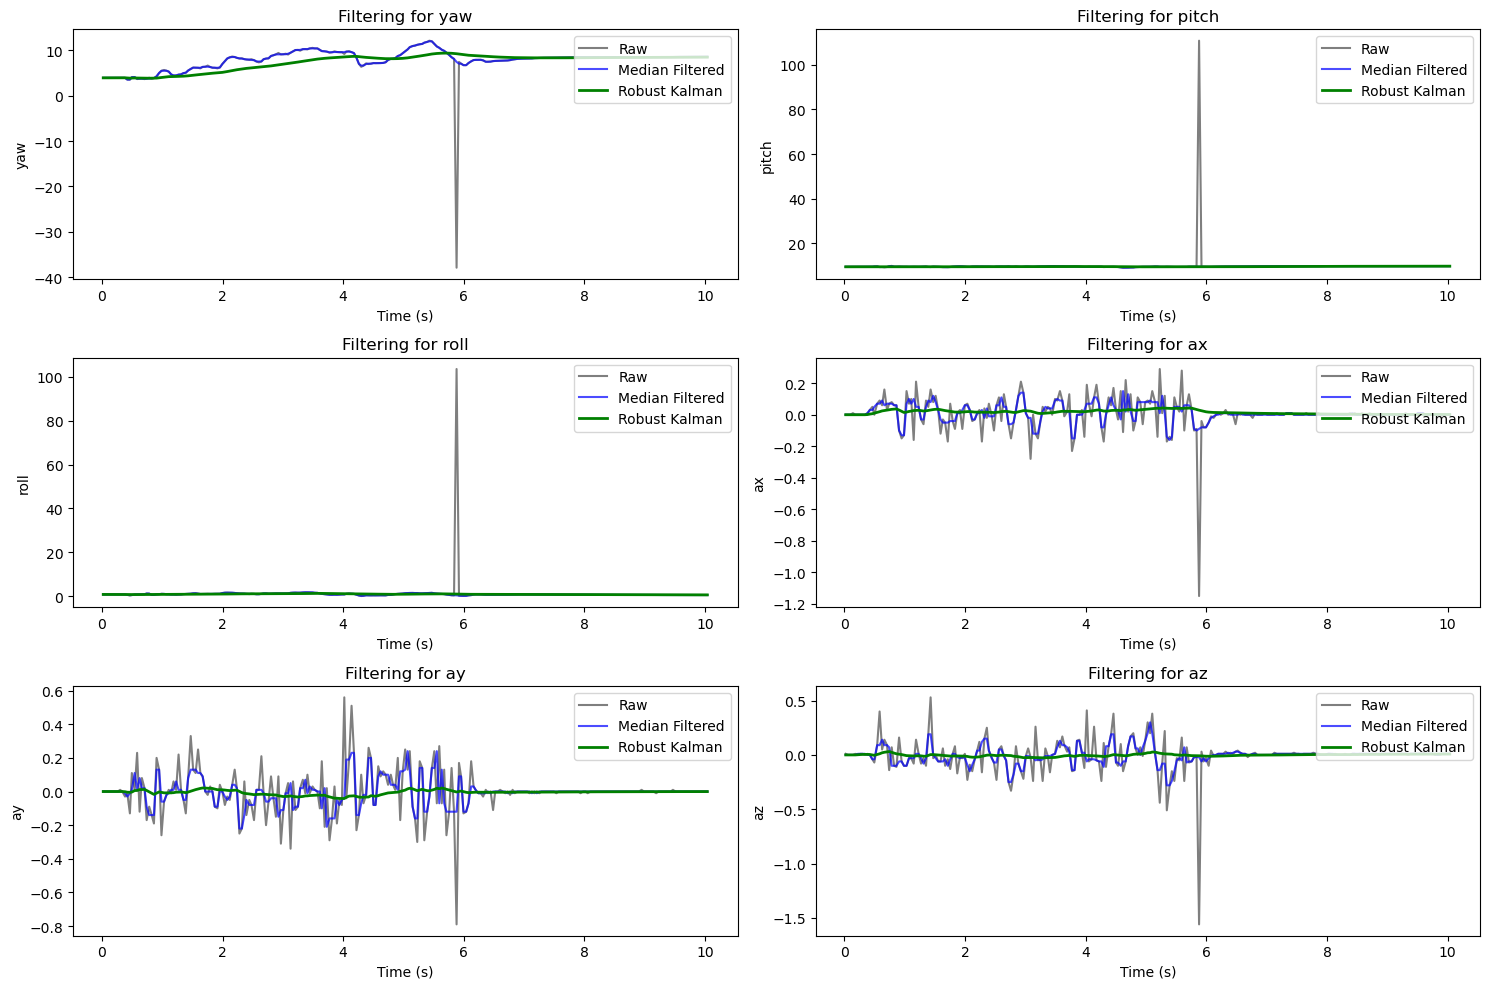

In [254]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_filter):
    plt.subplot(3, 2, i + 1)
    plt.plot(df["timestamp"], df[col], label="Raw", alpha=0.5, c="black")
    plt.plot(
        median_filtered_df["timestamp"],
        median_filtered_df[col],
        label="Median Filtered",
        alpha=0.7,
        c="b",
    )
    plt.plot(
        robust_filtered_df["timestamp"],
        robust_filtered_df[col],
        label="Robust Kalman",
        linewidth=2,
        c="g",
    )
    plt.xlabel("Time (s)")
    plt.ylabel(col)
    plt.legend(loc="upper right")
    plt.title(f"Filtering for {col}")

plt.tight_layout()
plt.show()

In [255]:
# for col in columns_to_filter:
#     fig = px.line(df, x="timestamp", y=col, labels={"timestamp": "Time (s)", col: "Value"}, title=f"Filtering for {col}")

#     fig.add_scatter(x=median_filtered_df["timestamp"], y=median_filtered_df[col], mode="lines",
#                     name="Median Filtered", line=dict(color="blue", width=1))

#     fig.add_scatter(x=robust_filtered_df["timestamp"], y=robust_filtered_df[col], mode="lines",
#                     name="Robust Kalman", line=dict(color="green", width=2))

#     fig.add_scatter(x=df["timestamp"], y=df[col], mode="lines",
#                     name="Raw", line=dict(color="black", width=1, dash="dot"))

#     fig.show()

In [257]:
df = pd.read_csv("median_filtered_df.csv")

# Convert acceleration from g to m/s²
df["ax"] *= 9.81
df["ay"] *= 9.81
df["az"] = df["az"] * 9.81 - 9.81  # Remove gravity

# Initialize velocity and position arrays
vx, vy, vz = [0], [0], [0]  # Initial velocity (m/s)
px, py, pz = [0], [0], [0]  # Initial position (m)

# Perform numerical integration
for i in range(1, len(df)):
    dt = df["timestamp"][i] - df["timestamp"][i - 1]  # Time step

    # Trapezoidal integration for velocity
    vx_new = vx[-1] + (min(0, df["ax"][i]) + min(0, df["ax"][i - 1])) * dt / 2
    vy_new = vy[-1] + (df["ay"][i] + df["ay"][i - 1]) * dt / 2
    vz_new = vz[-1] + (df["az"][i] + df["az"][i - 1]) * dt / 2

    vx.append(vx_new)
    vy.append(vy_new)
    vz.append(vz_new)

    # Trapezoidal integration for position
    px_new = px[-1] + (vx[-1] + vx[-2]) * dt / 2
    py_new = py[-1] + (vy[-1] + vy[-2]) * dt / 2
    pz_new = pz[-1] + (vz[-1] + vz[-2]) * dt / 2

    px.append(px_new)
    py.append(py_new)
    pz.append(pz_new)

# Add results to DataFrame
df["vx"], df["vy"], df["vz"] = vx, vy, vz
df["px"], df["py"], df["pz"] = px, py, pz
print("The Velocities in X-Y axes", vx[-1], vy[-1])
print("The positions in X-Y axes", px[-1], py[-1])

The Velocities in X-Y axes -1.2140379614710792 -0.29645682735443
The positions in X-Y axes -7.695128899317142 -2.3762995037997725
